# Exploring different data files to see what they look like

In [1]:
import rasterio
from rasterio.features import shapes
import geopandas as gpd
import pandas as pd
from shapely.geometry import box
from rasterio.mask import mask
import seaborn as sns
import matplotlib.pyplot as plt

### Exploring Atlas AI asset wealth file

In [2]:
# Open the TIFF file
tif_file = "../data/atlas_ai_files/Rwanda_Asset-Wealth-1912m_0_08_RWA_2016.tif"
boundary_shp_file = "../data/locations/rwanda_boundary/RWA_adm0.shp"

### Helper functions to clip tif files and process data into administrative regions

In [3]:
def get_admin_boundary(admin_level: str) -> str:
    """
    This function takes in the admin_level string and returns the file path to the shape file

    Input:
        - admin_level: A string indicating the admin level (district, sector, cell, village, or boundary)

    Returns:
        - String representing the shape file path
    """

    admin_paths = {
        "district": "../data/locations/district/District.shp",
        "sector": "../data/locations/sector/Sector.shp",
        "cell": "../data/locations/cell/Cell.shp",
        "village": "../data/locations/villages/Village.shp",
        "boundary": "../data/locations/rwanda_boundary/RWA_adm0.shp",
    }

    admin_ids = {
        "district": "Dist_ID",
        "sector": "Sect_ID",
        "cell": "Cell_ID",
        "village": "Village_ID",
        "boundary": None,
    }

    # Use the provided admin_level to directly access the file path from the dictionary
    admin_path = admin_paths.get(admin_level.lower())
    admin_id = admin_ids.get(admin_level.lower())

    if admin_path is None:
        raise ValueError(f"Invalid admin_level: {admin_level}")

    return admin_path, admin_id

In [4]:
def clip_tif_file(tif_file:str) -> gpd.GeoDataFrame:

    """
    This function clips a tiff file into the boundary required (i.e. Rwanda) and returns a 
    geopandas dataframe.

    Input:
        - tif_file: String denoting path to tif file
    Returns:
        - geopandas.GeoDataFrame: GeoDataFrame containing the clipped raster data
    """

    with rasterio.open(tif_file) as src:
        # Read raster data and geometry
        array = src.read(1)
        transform = src.transform

        # Open the boundary shapefile
        boundary_gdf = gpd.read_file(get_admin_boundary("boundary")[0])

        # Make sure both GeoDataFrames have the same CRS
        boundary_gdf = boundary_gdf.to_crs(src.crs)

        # Create a bounding box that covers the extent of the raster
        xmin, ymin, xmax, ymax = src.bounds
        bbox = box(xmin, ymin, xmax, ymax)
        bbox_gdf = gpd.GeoDataFrame(geometry=[bbox], crs=src.crs)

        # Intersect the bounding box with the boundary shapefile
        intersection = gpd.overlay(boundary_gdf, bbox_gdf, how='intersection')

        # Clip the raster to the intersection geometry
        clipped, transform = mask(src, shapes=intersection.geometry, crop=True)

        # Create a GeoDataFrame directly from the clipped raster
        shapes_gen = rasterio.features.shapes(clipped, transform=transform)
        features = [{'geometry': geometry, 'properties': {'pixel_value': value}}
                    for (geometry, value) in shapes_gen]
        gdf_clipped = gpd.GeoDataFrame.from_features(features, crs=src.crs)

        gdf_clipped = gdf_clipped.to_crs(("EPSG:4326"))

    return gdf_clipped


In [5]:
def compute_administrative_metric(gdf: gpd.GeoDataFrame, admin_level: str) -> gpd.GeoDataFrame:
    """
    This function takes in a geopandas dataframe of an index spread across pixels, 
    and localizes it to the region under study (i.e. sector, cell, or village).

    Inputs:
        - gdf: Geopandas Geodataframe containing the index being measured
        - admin_level: This is just a string showing if the amin level is 
            sector, cell, or village
        - admin_id: This is a string showing te unique identifier to an 
            admin region

    Returns:
        - gpd.GeoDataFrame with median calculations for 

    """

    # Get the file path and identifier for the specified admin level
    admin_path, admin_id = get_admin_boundary(admin_level=admin_level)

    # Read the admin shapefile
    admin_shp = gpd.read_file(admin_path)
    admin_shp = admin_shp.to_crs(("EPSG:4326"))

    # Perform intersection between admin shapefile and the given GeoDataFrame
    overlay = gpd.overlay(admin_shp, gdf, how="intersection")

    # Calculate median and retain the first geometry in case of multiple intersections
    index_summary = overlay.groupby([admin_id]).agg({
        "pixel_value": "median",
        "geometry": "first" 
    }).reset_index()


    # Index summary is joined to the initial admin_level file because by choosing first, it
    # only chooses the first index of gdf in the admin region and not the entire region
    index_summary = index_summary.loc[:, index_summary.columns != "geometry"].merge(
                        admin_shp[[admin_id, "geometry"]], on = f"{admin_id}",
                        suffixes=('_left', '_right'))
    
    index_summary = gpd.GeoDataFrame(index_summary, geometry="geometry", crs=admin_shp.crs)


    return index_summary

In [6]:
def plot_geopandas(gdf, column, figsize=(10, 8), cmap="Reds", 
                             colorbar_title="Colorbar Title", plot_title="plot title"):
    """
    This function plots a geopandas shapefile to show the disdribution of an attribute

    Parameters:
        - gdf: GeoPandas GeoDataFrame to be plotted.
        - column: Name of the column in the GeoDataFrame to be used for coloring.
        - figsize: Tuple specifying the figure size (default is (10, 8)).
        - cmap: Colormap to be used for coloring (default is "viridis").

    Returns:
        - None
    """
    # Set the style using seaborn
    sns.set_theme(style="ticks", palette="pastel")
    sns.set(font="Verdana", font_scale=0.7)

    

    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the GeoDataFrame with the specified column for coloring
    gdf.plot(column=column, cmap=cmap, linewidth=0.2, ax=ax, edgecolor="0.5")

    # Remove axis labels and boundary box
    ax.set_axis_off()

    # Show the colormap legend on the side with 4 decimal places and without the boundary box
    cax = fig.add_axes([0.92, 0.2, 0.05, 0.2])  # Adjust the position as needed
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=gdf[column].min(), vmax=gdf[column].max()))
    sm._A = []  # fake up the array of the scalar mappable
    cbar = fig.colorbar(sm, cax=cax, format="%.4f", drawedges=False)  # format="%.4f" for 4 decimal places

    # Set the title for the colorbar
    cbar.set_label(colorbar_title, rotation=270, labelpad=15)

    # Add title to the bottom of the plot
    plt.suptitle(plot_title, x=0.5, y=0.05, fontsize=12, fontname="Verdana",
                 ha='center', va='bottom')

    # Show the plot
    plt.show()


### Inspect different datasets for study

#### Atlas AI Files

In [8]:
# Asset Wealth

asset_wealth_2016_shp = clip_tif_file("../data/atlas_ai_files/Rwanda_Asset-Wealth-1912m_0_08_RWA_2016.tif")
asset_wealth_2017_shp = clip_tif_file("../data/atlas_ai_files/Rwanda_Asset-Wealth-1912m_0_08_RWA_2017.tif")
asset_wealth_2018_shp = clip_tif_file("../data/atlas_ai_files/Rwanda_Asset-Wealth-1912m_0_08_RWA_2018.tif")
asset_wealth_2019_shp = clip_tif_file("../data/atlas_ai_files/Rwanda_Asset-Wealth-1912m_0_08_RWA_2019.tif")
asset_wealth_2020_shp = clip_tif_file("../data/atlas_ai_files/Rwanda_Asset-Wealth-1912m_0_08_RWA_2020.tif")

sector_asset_wealth_2016 = compute_administrative_metric(asset_wealth_2016_shp, "sector")
sector_asset_wealth_2017 = compute_administrative_metric(asset_wealth_2017_shp, "sector")
sector_asset_wealth_2018 = compute_administrative_metric(asset_wealth_2018_shp, "sector")
sector_asset_wealth_2019 = compute_administrative_metric(asset_wealth_2019_shp, "sector")
sector_asset_wealth_2020 = compute_administrative_metric(asset_wealth_2020_shp, "sector")

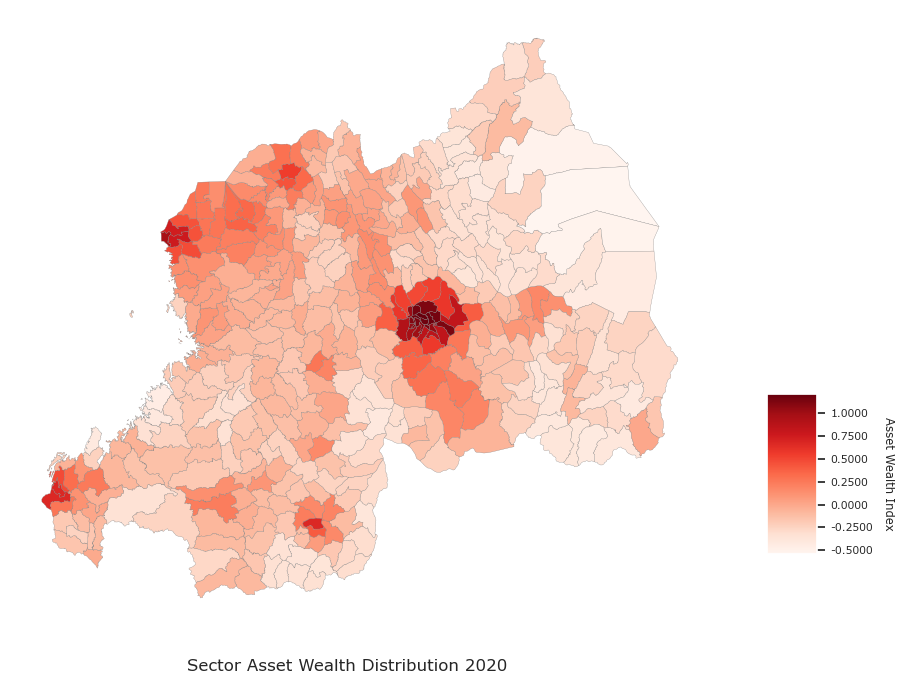

In [9]:

plot_geopandas(sector_asset_wealth_2020, "pixel_value", 
                         colorbar_title="Asset Wealth Index", plot_title="Sector Asset Wealth Distribution 2020")

In [10]:
# Built up index

# builtup_index_2016_shp = clip_tif_file("../data/atlas_ai_files/Rwanda_built-env_built-up-index_v3.0_RWA_2016.tif")
# builtup_index_2017_shp = clip_tif_file("../data/atlas_ai_files/Rwanda_built-env_built-up-index_v3.0_RWA_2017.tif")
# builtup_index_2018_shp = clip_tif_file("../data/atlas_ai_files/Rwanda_built-env_built-up-index_v3.0_RWA_2018.tif")
# builtup_index_2019_shp = clip_tif_file("../data/atlas_ai_files/Rwanda_built-env_built-up-index_v3.0_RWA_2019.tif")
# builtup_index_2020_shp = clip_tif_file("../data/atlas_ai_files/Rwanda_built-env_built-up-index_v3.0_RWA_2020.tif")

# builtup_index_2016 = compute_administrative_metric(builtup_index_2016_shp, "sector")
# builtup_index_2017 = compute_administrative_metric(builtup_index_2017_shp, "sector")
# builtup_index_2018 = compute_administrative_metric(builtup_index_2018_shp, "sector")
# builtup_index_2019 = compute_administrative_metric(builtup_index_2019_shp, "sector")
# builtup_index_2020 = compute_administrative_metric(builtup_index_2020_shp, "sector")


In [11]:
# builtup_index_2020

In [12]:
# Built up surface

# builtup_surface_2016_shp = clip_tif_file("../data/atlas_ai_files/Rwanda_built-env_built-up-surface_v3.0_RWA_2016.tif")
# builtup_surface_2017_shp = clip_tif_file("../data/atlas_ai_files/Rwanda_built-env_built-up-surface_v3.0_RWA_2017.tif")
# builtup_surface_2018_shp = clip_tif_file("../data/atlas_ai_files/Rwanda_built-env_built-up-surface_v3.0_RWA_2018.tif")
# builtup_surface_2019_shp = clip_tif_file("../data/atlas_ai_files/Rwanda_built-env_built-up-surface_v3.0_RWA_2019.tif")
# builtup_surface_2020_shp = clip_tif_file("../data/atlas_ai_files/Rwanda_built-env_built-up-surface_v3.0_RWA_2020.tif")

# builtup_surface_2016 = compute_administrative_metric(builtup_surface_2016_shp, "sector")
# builtup_surface_2017 = compute_administrative_metric(builtup_surface_2017_shp, "sector")
# builtup_surface_2018 = compute_administrative_metric(builtup_surface_2018_shp, "sector")
# builtup_surface_2019 = compute_administrative_metric(builtup_surface_2019_shp, "sector")
# builtup_surface_2020 = compute_administrative_metric(builtup_surface_2020_shp, "sector")

In [13]:
# builtup_surface_2020

In [14]:
# Spending

# spending_2016_shp = clip_tif_file("../data/atlas_ai_files/Rwanda_Spending-1912m_0_12_RWA_2016.tif")
# spending_2017_shp = clip_tif_file("../data/atlas_ai_files/Rwanda_Spending-1912m_0_12_RWA_2017.tif")
# spending_2018_shp = clip_tif_file("../data/atlas_ai_files/Rwanda_Spending-1912m_0_12_RWA_2018.tif")
# spending_2019_shp = clip_tif_file("../data/atlas_ai_files/Rwanda_Spending-1912m_0_12_RWA_2019.tif")
spending_2020_shp = clip_tif_file("../data/atlas_ai_files/Rwanda_Spending-1912m_0_12_RWA_2020.tif")

# spending_2016 = compute_administrative_metric(spending_2016_shp, "sector")
# spending_2017 = compute_administrative_metric(spending_2017_shp, "sector")
# spending_2018 = compute_administrative_metric(spending_2018_shp, "sector")
# spending_2019 = compute_administrative_metric(spending_2019_shp, "sector")
spending_2020 = compute_administrative_metric(spending_2020_shp, "sector")

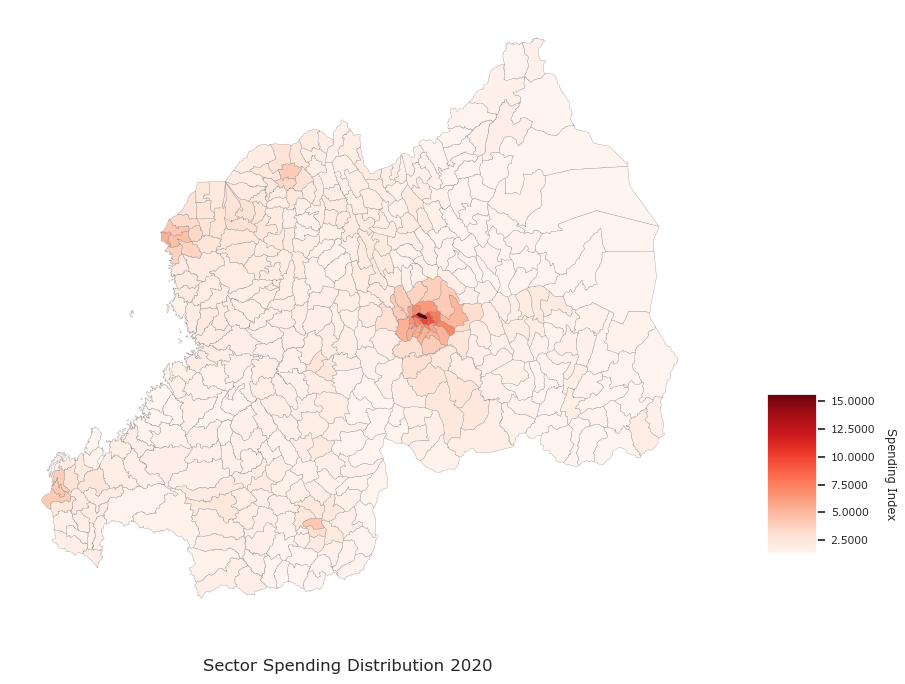

In [15]:
plot_geopandas(spending_2020, "pixel_value", 
                         colorbar_title="Spending Index", plot_title="Sector Spending Distribution 2020")

### European Commission GHSL - Global Human Settlement Layer

In [16]:
## Built-up Characteristics

builtup_char_shp = clip_tif_file("../data/european_commision/GHS_BUILT_C_MSZ_E2018_GLOBE_R2023A_54009_10_V1_0.tif")
builtup_char_2018 = compute_administrative_metric(builtup_char_shp, "sector")

: 

In [11]:
# Built-up Surface

builtup_surf_2010_shp = clip_tif_file("../data/european_commision/GHS_BUILT_S_E2010_GLOBE_R2023A_54009_100_V1_0.tif")
builtup_surf_2015_shp = clip_tif_file("../data/european_commision/GHS_BUILT_S_E2015_GLOBE_R2023A_54009_100_V1_0.tif")
builtup_surf_2020_shp = clip_tif_file("../data/european_commision/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_100_V1_0.tif")

builtup_surf_2010 = compute_administrative_metric(builtup_surf_2010_shp, "sector")
builtup_surf_2015 = compute_administrative_metric(builtup_surf_2015_shp, "sector")
builtup_surf_2020 = compute_administrative_metric(builtup_surf_2020_shp, "sector")

: 

In [8]:
# Degree of Urbanization

urban_2010_shp = clip_tif_file("../data/european_commision/GHS_SMOD_E2010_GLOBE_R2023A_54009_1000_V1_0.tif")
urban_2015_shp = clip_tif_file("../data/european_commision/GHS_SMOD_E2015_GLOBE_R2023A_54009_1000_V1_0.tif")
urban_2020_shp = clip_tif_file("../data/european_commision/GHS_SMOD_E2020_GLOBE_R2023A_54009_1000_V1_0.tif")

urban_2010 = compute_administrative_metric(urban_2010_shp, "sector")
urban_2015 = compute_administrative_metric(urban_2015_shp, "sector")
urban_2020 = compute_administrative_metric(urban_2020_shp, "sector")

In [9]:
urban_2020

,Sect_ID,pixel_value,geometry
0,1101.0,30.0,"POLYGON ((30.04829 -1.94176, 30.04833 -1.94178..."
1,1102.0,21.0,"POLYGON ((29.98964 -1.86756, 29.98957 -1.86789..."
2,1103.0,12.0,"POLYGON ((30.04030 -1.94181, 30.04036 -1.94183..."
3,1104.0,30.0,"POLYGON ((30.04496 -1.93947, 30.04501 -1.93955..."
4,1105.0,12.0,"POLYGON ((30.05227 -2.00171, 30.05232 -2.00175..."
...,...,...,...
411,5711.0,12.0,"POLYGON ((30.02756 -2.26839, 30.02810 -2.26985..."
412,5712.0,12.0,"POLYGON ((30.17277 -2.11490, 30.17365 -2.11542..."
413,5713.0,11.5,"POLYGON ((30.09253 -2.28683, 30.09287 -2.28766..."
414,5714.0,12.0,"POLYGON ((30.32350 -2.19875, 30.32362 -2.19909..."


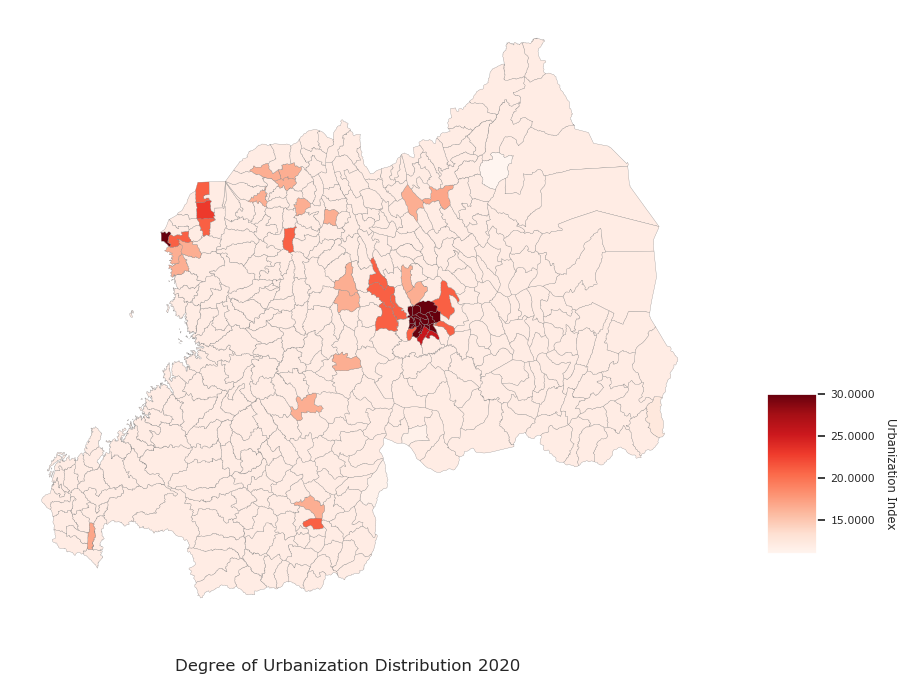

In [10]:
plot_geopandas(urban_2020, "pixel_value", colorbar_title="Urbanization Index", 
               plot_title="Degree of Urbanization Distribution 2020")